# <u>Prediction of Assessed Zillow  Property Tax Values </u> 


Stephen Kipkurui | Junior Zillow Data Scientist

## Project Introduction
### This project is necessitated by our Zillow Data Science Team in understanding drivers for property tax in the year 2017. Although the team here has a feature prediction model, we intend to create a completely new model from an outside perspective to compliment the old model and explore possible ways to improve it. 

## Library Imports 

In [107]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from acquire import get_zillow
from prepare import prepare_zillow
from scipy.stats import pearsonr, spearmanr

import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE, SequentialFeatureSelector

from evaluate import select_kbest_feature_engineering, rfe_feature_engineering
from evaluate import scaled_data, assessed_value_regression_plot, baseline_vs_model_regression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

# <u>Executive Summary:</u>

>- A home square feet is a feature that predicts highly the asssessed tax value at 29%
>- Second key factor is bathroom count at 27% and bedroom count at 13%. 
>- 3 Models build- Linear regression, Polynomial regression, and Tweedie Regression. 
>- With __Bed, bath and sqaure feet__ features. <u>Polynomial Regression</u> performed better than other two models predicting tax value with RMSE value of $183,353.21$ vs baseline of $193,231.11$
>- Adding __built year, zip code, home age, transaction month__ onto the above features resulted in <u>Linear regression model</u> beating the other model as predictor of tax value with predicted RMSE of $186,353.21$ vs baseline of $193,231.11$.
>- ##### <u>Overall Polynomial regression model best predictors of tax withe bed, bath, square feet. </u>

- ### Models:

     - Linear Regressions 
     - Polynomial Regression I
     - Tweedie Regression
     
- ### Recommendations:

     - With time that was provided, these are main features we examined, more unseen features could still be possible predictors of tax values and in future, would be appropriate to examine.


# Data Science Pipeline

# (A). Planning 

- #### The stakeholder --> Zillow Data Sceince Team
- #### Business objective --> create additional model that predicts home assessed tax values as additional tool to the current model. 
- #### Data source --> CodeUp\'s online SQL Database 2017 Zillow. (Date of acquisition: March, 2022).


### Additional Setups 
- ##### GitHub Repository (<u>git@github.com:stephenkipkurui/regression-project.git</u>). 
- ##### Mitigate data leakage. (No leakage into test set exprienced in this project)
- ##### Documented process and delivery report


# (B). Data Acquisition 

In [9]:
# Call the data acquisiotion that in-turn calls the prepare function:(drop outliers, drop duplicates, 
# renamed columns, dropped nulls and encoded data)

train, validate, test = prepare_zillow()

Status: Acquiring data from cached csv file..


### Prepare.py module...
- ##### Dropped any duplicates & null data rows
- ##### Renamed columns {
                   'bedroomcnt':'bed_count','bathroomcnt':'bath_count',
                   'calculatedfinishedsquarefeet':'square_feet',
                   'taxvaluedollarcnt':'assessed_value', 'fips':'fips',
                   'yearbuilt':'year_built','transactiondate':'trans_date'
                   }

- ##### Created a 'home_age' from year_built columns and 'city' columns from fips using U.S. Federal resources (https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697)                   
                   
- ##### Removed outliers on columns ('bed_count', 'bath_count', 'square_feet','assessed_value','trans_month')
- ##### Lastly, split the date in ratios below.

In [10]:
# Check the shape integrity

print(f'\n\tTrain Shape: {train.shape} \n\tValidate Shape:  {validate.shape} \n\tTest Shape {test.shape}')


	Train Shape: (21752, 8) 
	Validate Shape:  (9323, 8) 
	Test Shape (7769, 8)


In [110]:
# Examine the train sets integrity

train.head(2)

,bed_count,bath_count,square_feet,assessed_value,trans_month,trans_day,built_year,zip_code,city,home_age,square_feet_scaled,age_scaled,assessed_val_scaled,bed_scaled,bath_scaled
52025,4.0,2.5,2273.0,632472.0,9,14,1996,6059,Orange,47,1.735931,-3.357907,1443.843361,-3.456305,-3.459738
44995,3.0,1.0,1087.0,220726.0,8,9,1951,6037,Los Angeles,47,-0.978037,-3.357907,501.629924,-3.458593,-3.463170


# (C). Preparation



##### Additional cleaning and renaming columns 

In [13]:
# Split trans date into month and date and remove trailing .0 from year_built

train['trans_month'] = pd.DatetimeIndex(train['trans_date']).month
train['trans_day'] = pd.DatetimeIndex(train['trans_date']).day
train['built_year'] = train['year_built'].astype('int64')
train['zip_code'] = train['fips'].astype('int64')

train = train.drop(columns = ['trans_date', 'year_built','fips'])

validate['trans_month'] = pd.DatetimeIndex(validate['trans_date']).month
validate['trans_day'] = pd.DatetimeIndex(validate['trans_date']).day
validate['built_year'] = validate['year_built'].astype('int64')
validate['zip_code'] = validate['fips'].astype('int64')

validate = validate.drop(columns = ['trans_date', 'year_built','fips'])

test['trans_month'] = pd.DatetimeIndex(test['trans_date']).month
test['trans_day'] = pd.DatetimeIndex(test['trans_date']).day
test['built_year'] = test['year_built'].astype('int64')
test['zip_code'] = test['fips'].astype('int64')

test = test.drop(columns = ['trans_date', 'year_built', 'fips'])


train['city'] = train.zip_code.replace({6037: 'Los Angeles', 6059:'Orange', 6111:'Ventura'})
validate['city'] = validate.zip_code.replace({6037: 'Los Angeles', 6059:'Orange', 6111:'Ventura'})
test['city'] = test.zip_code.replace({6037: 'Los Angeles', 6059:'Orange', 6111:'Ventura'})



### Calculate the Home\'s Age 

In [16]:
from datetime import datetime, date

train_scaled = train.copy()
validate_scaled = validate.copy()
test_scaled = test.copy()


# train_scaled = train_scaled.drop(columns = ['city'])
# validate_scaled = validate_scaled.drop(columns = ['city'])
# test_scaled = test_scaled.drop(columns = 'city')


train_scaled["built_year"] = pd.to_datetime(train_scaled["built_year"])
validate_scaled["built_year"] = pd.to_datetime(validate_scaled["built_year"])
test_scaled["built_year"] = pd.to_datetime(test_scaled["built_year"])


train["home_age"] = train_scaled["built_year"].apply(lambda x : (pd.datetime.now().year - x .year))
validate["home_age"] = validate_scaled["built_year"].apply(lambda x : (pd.datetime.now().year - x.year))
test["home_age"] = test_scaled["built_year"].apply(lambda x : (pd.datetime.now().year - x.year))

# Subtract 5 years from current date to get year 2017
train['home_age'] = train_scaled['home_age'] - 5
validate['home_age'] = validate_scaled['home_age'] - 5
test['home_age'] = test_scaled['home_age'] - 5

### Scaled the Data (Standard Scaler)

In [17]:
# 1. create the object
scaler = sklearn.preprocessing.StandardScaler()

# 2. fit the object
scaler.fit(train_scaled[['square_feet']])

# 3. use the object. Scale total_bill only
train['square_feet_scaled'] = scaler.transform(train_scaled[['square_feet']])
test['square_feet_scaled'] = scaler.transform(test_scaled[['square_feet']])
validate['square_feet_scaled'] = scaler.transform(validate_scaled[['square_feet']])

# Add scaled age columns
train['age_scaled'] = scaler.transform(train[['home_age']])
test['age_scaled'] = scaler.transform(test[['home_age']])
validate['age_scaled'] = scaler.transform(validate[['home_age']])

 # Add scalled assessed value columns
train['assessed_val_scaled'] = scaler.transform(train[['assessed_value']])
test['assessed_val_scaled'] = scaler.transform(test[['assessed_value']])
validate['assessed_val_scaled'] = scaler.transform(validate[['assessed_value']])
# add scaled bed columns
train['bed_scaled'] = scaler.transform(train[['bed_count']])
test['bed_scaled'] = scaler.transform(test[['bed_count']])
validate['bed_scaled'] = scaler.transform(validate[['bed_count']])
# Add scaled bath columns
train['bath_scaled'] = scaler.transform(train[['bath_count']])
test['bath_scaled'] = scaler.transform(test[['bath_count']])
validate['bath_scaled'] = scaler.transform(validate[['bath_count']])


## Moving forward with only the train set
- NOTE: validate and test sets used to evaluate the model on unseen data

# (D). Exploration

## Reminder project goal:- create a model to predict assessed values...

## Initial questions?
- ### How is a home\s assessed tax value correlated with:-
>- ##### The number of bedrooms?
>- ##### The number of bathrooms?
>- ##### Home square feet?
>- ##### Transaction month?
>- ##### Home\'s location?
>- ##### Home's ages till 2017?

### With more time...
- ##### Home size
- ##### Lot size home is build



## Visualizations 

## (i). Square Feet Distribution

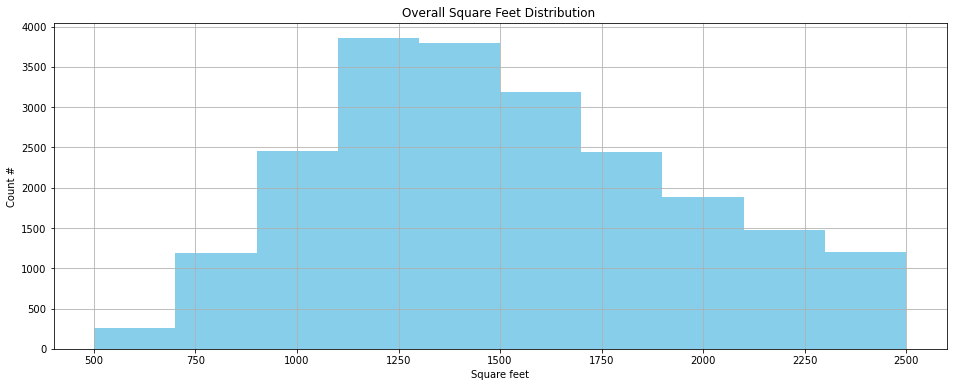

In [112]:
plt.figure(figsize = (16, 6))
plt.title('Overall Square Feet Distribution ')
plt.ylabel('Count #')
plt.xlabel('Square feet')
train.square_feet.hist(color = "skyblue", lw=0)
plt.show()

##### Outliers removed --> Fairly normal distributed with slight right skewness

## (ii). Bedrooms & Bath Counts Distribution

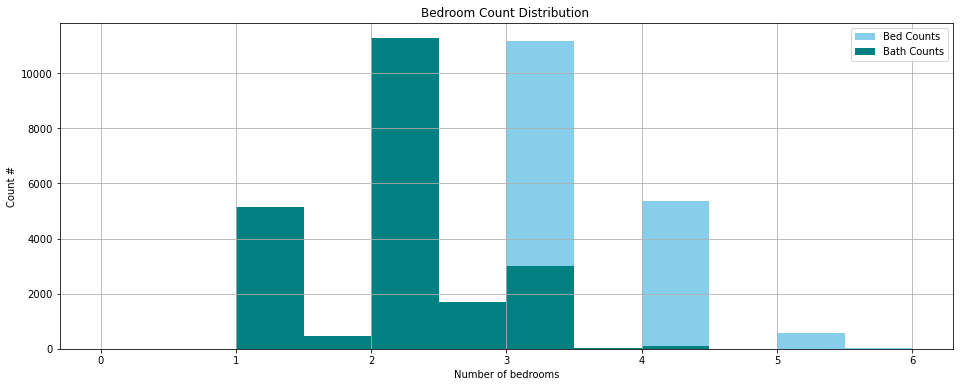

In [113]:
plt.figure(figsize = (16, 6))
plt.title('Bedroom Count Distribution ')
plt.ylabel('Count #')
plt.xlabel('Number of bedrooms')
train.bed_count.hist(color = "skyblue", lw=0, label = 'Bed Counts')
train.bath_count.hist(color = "teal", lw=0, label = 'Bath Counts')
plt.legend()
plt.show()

##### Outliers removed --> 2 bathrooms & 3 bedroom home most common followed by 1 bedroom and 1 bath 

### (iii) Home Age/ Build year

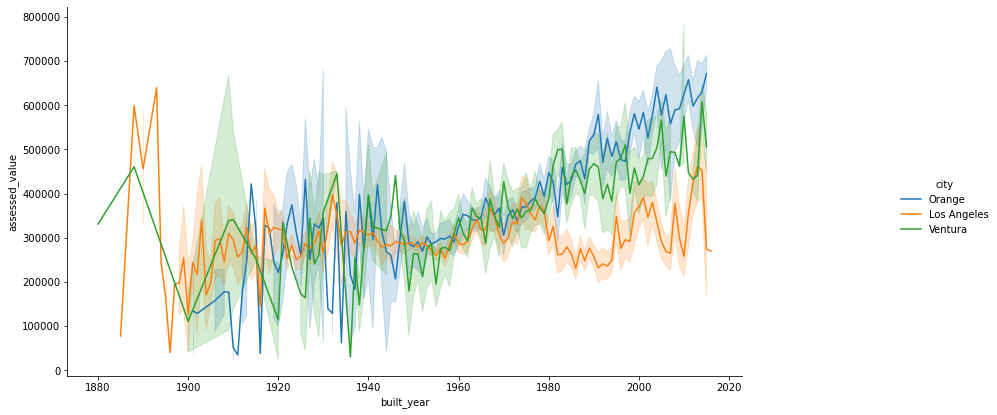

In [114]:
sns.relplot(data = train, x = 'built_year', y = 'assessed_value', hue = 'city', kind = 'line')
plt.gcf().set_size_inches(16, 6)


##### Before the 1900s homes tax values dropped shaply then has had steady rise with Los Angeles County dragging lower than Orange & Ventura Counties.  

### (iv). Assessed Value Distribution by Location

In [116]:
la_assessed_val_avg = train[train.city == 'Los Angeles'].assessed_value.mean()
ventura_assessed_val_avg = train[train.city == 'Ventura'].assessed_value.mean()
orange_assessed_val_avg = train[train.city == 'Orange'].assessed_value.mean()
print('\nMean average assessed tax values by counties\n')
print(f'\tL.A. County: --- {la_assessed_val_avg} \n\tVentura County: --- {ventura_assessed_val_avg}\n\tOrange County: --- {orange_assessed_val_avg}')


Mean average assessed tax values by counties

	L.A. County: --- 289952.93321460375 
	Ventura County: --- 360565.0263308529
	Orange County: --- 370287.64927857934


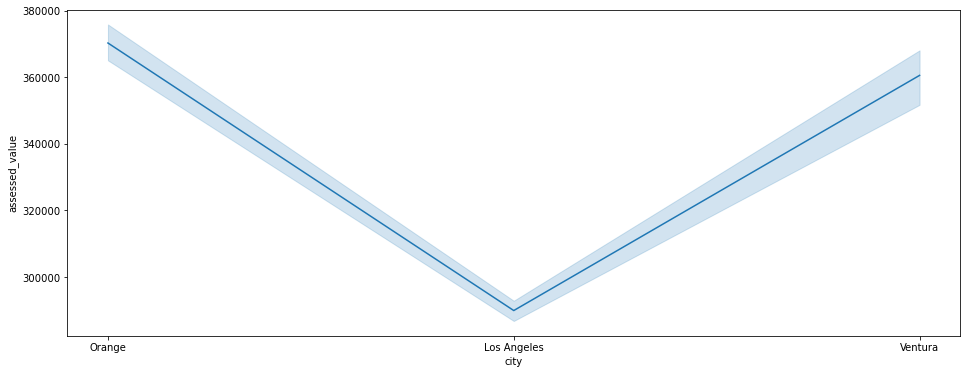

In [123]:
sns.lineplot(data=train, x="city", y="assessed_value")
plt.gcf().set_size_inches(16, 6)

##### L.A. Has lowest assessed tax values, followed by Ventura then Orange Counties.


### (V). Monthly Average Assessed Values 

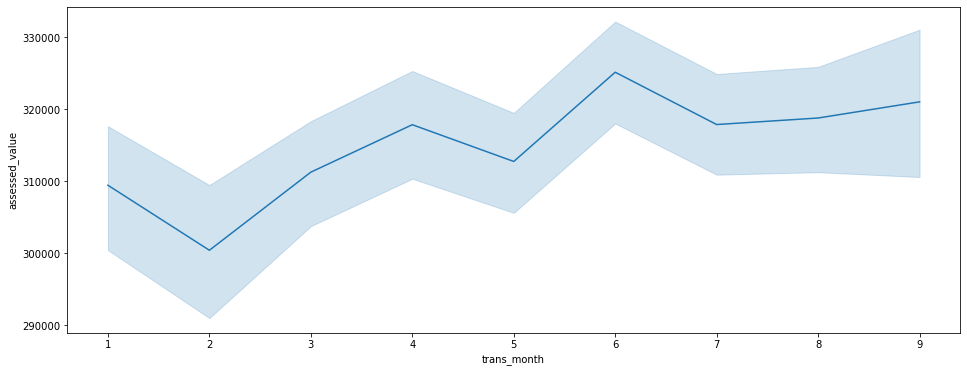

In [127]:
sns.lineplot(data=train, x="trans_month", y="assessed_value")
plt.gcf().set_size_inches(16, 6)

##### Drops Jan - Feb, steady rise till April dips in May, rise in June then plateaus 

## Key Findings:
##### __NOTE:__ Some bed count and room counts were removed by the outlier functions as they were far and wide
>- 3 bedroom and 2 baths are the most common household classifications in 2017
>- Least desired/ (not transactioned) homes were those build in 1900s followed by those built between mid 1900s to about 1918s. (...or was there enough data then?)
>- Surprisingly, homes built about 1918s to late 1940s outperformed those built after about 2005
>- Most transactions were average throughout the year but peaked towards June.

## <u>Feature Engineering</u> 

## What features are key predictors (correlates) of assessed value?

>## Approach:
### (i). SelectKBest Test 

>##### Index(['bed_count', 'bath_count', 'square_feet']

### (ii). Reccursive Feature Elimination

> ##### Index(['bed_count', 'bath_count', 'square_feet', 'transaction month', 'zip code', 'home age']


### Feature Engineering Findings: 

>- __Bedroom count, Bathroom count & home square feet__ are KEY predictors of assessed value.


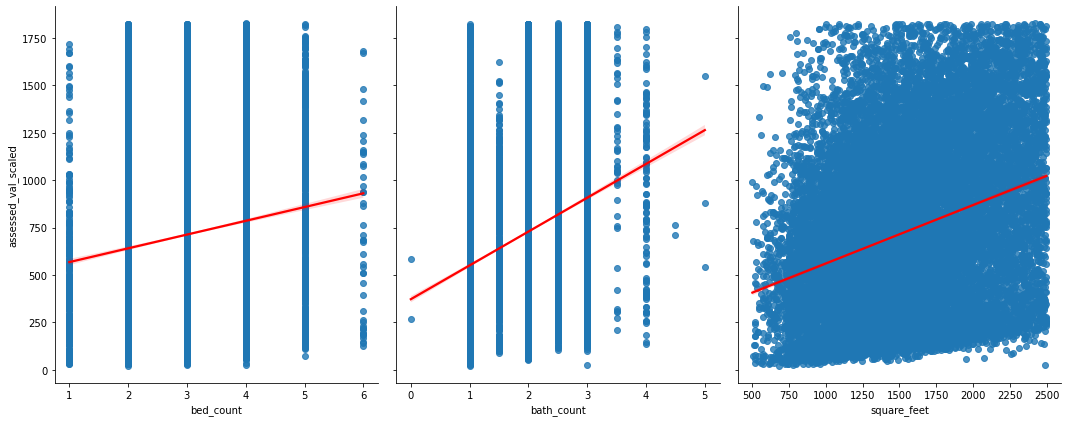

In [23]:
g = sns.pairplot(train, kind='reg', plot_kws={'line_kws':{'color':'red'}}, x_vars = ['bed_count', 'bath_count', 'square_feet'], 
                 y_vars = ['assessed_val_scaled'])

g.fig.set_size_inches(16,7)

## Further Verification with SpearmanR Test

In [24]:
# Spearman (Normally distributed

zillow_spearman = train.drop(columns=['city','trans_day', 'zip_code','built_year', 
                                    'trans_month', 'zip_code', 'home_age','square_feet_scaled',
                                    'age_scaled', 'assessed_val_scaled','bed_scaled',
                                      'bath_scaled']).corr(method='spearman')
zillow_spearman


,bed_count,bath_count,square_feet,assessed_value
bed_count,1.000000,0.546268,0.590021,0.129102
bath_count,0.546268,1.000000,0.739430,0.274831
square_feet,0.590021,0.739430,1.000000,0.292677
assessed_value,0.129102,0.274831,0.292677,1.000000


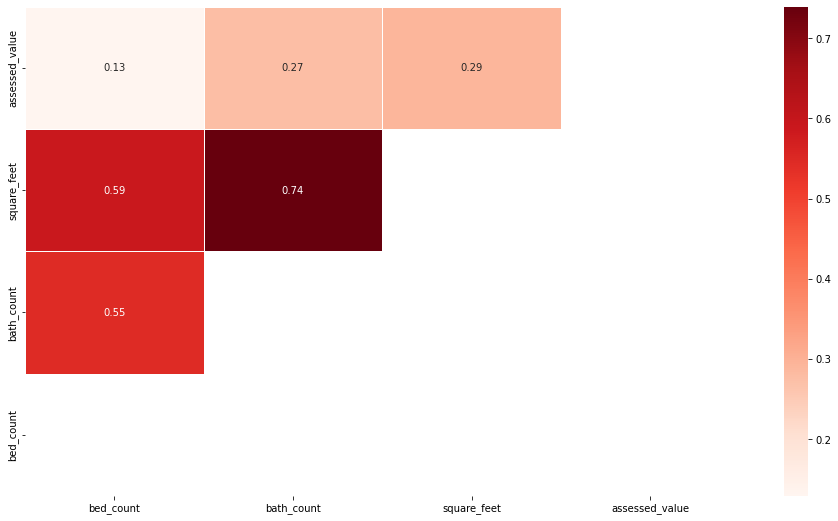

In [132]:
zillow_corr = train.drop(columns = ['city','trans_day', 'zip_code','built_year', 
                                    'trans_month', 'zip_code', 'home_age','square_feet_scaled',
                                    'age_scaled', 'assessed_val_scaled','bed_scaled','bath_scaled']).corr()

plt.figure(figsize=(16,9))

sns.heatmap(zillow_spearman, cmap='Reds', annot = True, linewidth=0.5, mask= np.triu(zillow_corr))

plt.ylim(0, 4)

plt.show()


## Exploration Phase Take Away: 
> ##### SpearmanR, SelectKBest and Recurssive Feature Elimination all point to square feet as main diver followed bt bathroom count and 3rd bedroom count.
    


# (E). Modeling

>- ### (a). Linear Regression Model
    
>- ### (b). Polynomial Regression Model
    
>- ### (c). Tweedie Regression (GLM) Model


### Set Driver Features of Interest

In [47]:
X_train = train[['bed_count', 'bath_count', 'square_feet']]
y_train = train.assessed_value

X_validate = validate[['bed_count', 'bath_count', 'square_feet']]
y_validate = validate.assessed_value

X_test = test[['bed_count', 'bath_count', 'square_feet']]
y_test = test.assessed_value

### Create Baseline

In [63]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict asssessed_values_pred_mean
asssessed_value_pred_mean = y_train['assessed_value'].mean()
y_train['asssessed_value_pred_mean'] = asssessed_value_pred_mean
y_validate['asssessed_value_pred_mean'] = asssessed_value_pred_mean

# 2. compute asssessed_values_pred_median
asssessed_value_pred_median = y_train['assessed_value'].median()
y_train['asssessed_value_pred_median'] = asssessed_value_pred_median
y_validate['asssessed_value_pred_median'] = asssessed_value_pred_median

# 3. RMSE of asssessed_values_pred_mean
rmse_train = mean_squared_error(y_train.assessed_value, y_train.asssessed_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.assessed_value, y_validate.asssessed_value_pred_mean)**(1/2)

print("\nRMSE USING MEAN #1\n\tTrain/In-Sample:", round(rmse_train, 2),
      "\n\tValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of asssessed_values_pred_median
rmse_train = mean_squared_error(y_train.assessed_value, y_train.asssessed_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.assessed_value, y_validate.asssessed_value_pred_median)**(1/2)

print("\n\nRMSE USING MEDIAN #1\n\tTrain/In-Sample: ", round(rmse_train, 2), 
      "\n\tValidate/Out-of-Sample: ", round(rmse_validate, 2))
print()


RMSE USING MEAN #1
	Train/In-Sample: 193231.11 
	Validate/Out-of-Sample:  193416.03


RMSE USING MEDIAN #1
	Train/In-Sample:  194294.19 
	Validate/Out-of-Sample:  194651.93



# Linear Regression (OLS) Model

In [64]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.assessed_value)

# predict train
y_train['assessed_val_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.assessed_value, y_train.assessed_val_pred_lm)**(1/2)

# predict validate
y_validate['assessed_val_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_value, y_validate.assessed_val_pred_lm)**(1/2)
print()
print("RMSE FOR OLS USING LINEAR-REGRESSION(Bed, bath & Square Feet) #1:\n\n\tTraining/In-Sample: ", rmse_train, 
      "\n\n\tValidation/Out-of-Sample: ", rmse_validate)
print()


RMSE FOR OLS USING LINEAR-REGRESSION(Bed, bath & Square Feet) #1:

	Training/In-Sample:  183077.00964762436 

	Validation/Out-of-Sample:  183293.08873430008



# ITERATION #1:  

>## Features of Interest:
>- ##### bed_count
>- ##### bath_count
>- ##### square_feet

<h1>SUMMARY 1</h1>

<h2>Features of interest: ('bed_count', 'bath_count', 'square_feet')</h2>


<hr>
<style>
td{
  font-size: 100px
}
</style>


<table style="width:100%, border: 1px solid green, border-collapse: collapse">
    
  <tr>
    <th>RMSE Mean Baseline </th>
    <th>RMSE Median Baseline</th>
    <th>RMSE Linear Regression Model</th>
    <th>RMSE Polynomial Regression Model</th>
    <th>RMSE TreedieRegression Model</th>

  </tr>

  <tr style="height:50px">
    <td>Train(in-sample): 193,231.11</td>
    <td>194,294.19</td>
    <td>183,077.01</td>
    <td>182,939.87</td>
    <td>193,231.11</td>

  </tr>

  <tr style="height:50px">
    <td>Validate(out-sample):  193,416.03</td>
    <td>194,651.93</td>
    <td>183,293.09</td>
    <td>183,306.67</td>
    <td>193,416.03</td>
  </tr>
   
</table>



### Linear Regression - Mean BaseLine
### Train Set
| RMSE Mean Baseline | (LINEAR ERROR DELTA) | (POLYNOMIAL ERROR DELTA) | (TWEEDIE ERROR DELTA) |
| --- | --- | --- | --- |
| (193,231.11) | -10,154.10 | -10,291.24 |  0.0  |


### Validate Set
| RMSE Mean Baseline | (LINEAR ERROR DELTA) | (POLYNOMIAL ERROR DELTA) | (TWEEDIE ERROR DELTA) |
| --- | --- | --- | --- |
| (193,416.03) | -10,122.94 | -10,109.36 |  0.0  |



# Evaluate Best Model (1st iteration):
- ##### The RMSE mean is lower than the Median Baseline, we will stick with the mean baseline
- ##### With train set, the Linear regression model performs overall best __-10,154.10__
- ##### With validate set, the Polynomial regression performs better than the other models __-10,109.36__


# Best Model (1st) == <u><b>Polynomial regression</b></u>

## Moving forward >>>> test adopted model on test set

In [65]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['assessed_val_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.assessed_value, y_test.assessed_val_pred_lm)**(1/2)

print("\n\tRMSE for OLS Model using LinearRegression\n\tOut-of-Sample Performance: ", rmse_test)
print()


	RMSE for OLS Model using LinearRegression
	Out-of-Sample Performance:  183353.20727252585



>># Test data:

- ### (i). Polynomial Regression beats Baseline Tax Value of $193,231.11$ (USD) by prediction of over $10,000$ (USD) ($183,353.21$) (USD).



<hr>-----------------------------------------------------------------------------------------------------------------------------------------------</hr>







<h1> ITERATION #2 </h1>
    

>## Features of interest:
>- square_feet
>- built_year
>- zip_code 
>- bed_count
>- bath_count
>- square_feet
>- age_scaled
>- trans_month

<hr>

<style>
td {
  font-size: 50px
}
</style>
# SUMMARY 2


<table style="width:100%, border: 1px solid green, border-collapse: collapse">
    
  <tr style="height:50px">
    <th>RMSE Mean Baseline </th>
    <th>RMSE Median Baseline</th>
    <th>RMSE Linear Regression Model</th>
    <th>RMSE Polynomial Regression Model</th>
    <th>RMSE TreedieRegression Model</th>

  </tr>

  <tr style="height:50px">
    <td>Train(in-sample): 193,231.11</td>
    <td>194,294.19</td>
    <td>183,090.23</td>
    <td>180,645.72</td>
    <td>193,231.11 </td>

  </tr>

  <tr style="height:50px">
    <td>Validate(out-sample):  193,416.03</td>
    <td>194,651.93</td>
    <td>183,288.87</td>
    <td>180,576.66</td>
    <td>193,416.03</td>
  </tr>    
    
</table>

### Linear Regression - Mean BaseLine
### Train Set
| RMSE Mean Baseline | (LINEAR ERROR DELTA) | (POLYNOMIAL ERROR DELTA) | (TWEEDIE ERROR DELTA) |
| --- | --- | --- | --- |
| (193,231.11) | -10,140.88 | -12,585.39 |  0.0  |


### Validate Set
| RMSE Mean Baseline | (LINEAR ERROR DELTA) | (POLYNOMIAL ERROR DELTA) | (TWEEDIE ERROR DELTA) |
| --- | --- | --- | --- |
| (193,416.03) | -9,942.24| -12,654.45 |  0.0  |


## Evaluate Best Model:
- ##### The RMSE mean is lower than the Median Baseline, we will stick with the mean baseline
- ##### Both the train set & validation sets for Linear regression model performs overall best __-10,140.88 & -9,942.24__ respectively.

# Best model (2nd) == <u><b>Linear regression</b></u>

## Moving forward >>>> test adopted model on test set

In [109]:
y_test2 = pd.DataFrame(y_test2)

# predict on test
y_test2['assessed_val_pred_lm2_2'] = lm2_2.predict(X_test2)

# evaluate: rmse
rmse_test2 = mean_squared_error(y_test2.assessed_value, y_test2.assessed_val_pred_lm2_2)**(1/2)

print("\n\tRMSE for OLS Model using LinearRegression\n\tOut-of-Sample Performance: ", rmse_test2)
print()

    RMSE for OLS Model using LinearRegression
    Out-of-Sample Performance:  186,430.67




>># Test data:

- ### 2nd iteration Linear Regression beats Baseline Tax Value of $193,231.11$ (USD) by predicting Tax value of $186,353.21$ (USD).

# Conclusion

- ## Overall tax prediction is achieved by Polynomial Regression(Root Mean Squared Error of USD 183,353.21 vs Baseline USD 193,231.11) - a USD 10,000 difference.
- ## Square feet is the key driver for assessed value folowed by bath room count, and lastly bedroom count.

- ## Varying the features, Linear progression model seem to perform better than Polynomial regression.


# Recommendations
- #### Square feet has consistently been the key driver for tax value. Bathrooma room and bedrooms follows closely.
- #### This dataset has way more features that could be combined to create unseen predictors to tax value such as days of the month, size of the home, among others that could be examined in the future. 

# Appendix


##### This report serves as a final document that discusses findings for this project in determining key predictions to our Zillow assessed value for Orange, Los Angeles, and Ventura Counties. The data used was for 2017 single households. However this model is not limited to that years alone. I could be modified for other years and cities. 

#### Overall, to predict bedroom count, bathroom counts, and home sqaure feet, the best model to utelize is Polynomial regression as it performed much better than Linear regression, and Tweedie Regression as compared to the baseline.


##### Predicting key predictor for features square_feet, built_year, zip_code, bed_count, bath_count, square_feet, age_scaled, trans_month, the best model that performed better that then baseline and others was Linear Regression. This is shown above with iteration number 2.

##### To reproduce this project, please read the README.md file located on Git Hub together with other resources for this project. Link: https://github.com/stephenkipkurui/regression-project
